# MS2 experimental spectrum to database search

This documentation describes the various methods implemented in the ms2matcher package. First we will provide a short demonstration on how to use the package and later we will show how the underlying functions work and the intermediate output that they provide.

In addition to this document, the main functions can all be found in the \ms2matcher folder in the main module file ms2matcher.py. All methods are documented according to the  NumPy/SciPy style convention (https://github.com/numpy/numpy/blob/master/doc/HOWTO_DOCUMENT.rst.txt), providing a clear overview of the required inputs and delivered outputs for each method, as well as the design philosephy and inter-dependencies between the methods.

# Using the software

The package can be run via the command line by calling 'python main.py' followed by the absolute path to a folder containing the experimental spectrum .dta files and optionally the MS1 ( '-t1 --toleranceMS1' ) and MS2 mass tolerance ( '-t2 --toleranceMS2' ). The default values are 50 ppm and 0.1 Dalton respectively.

<pre>
python main.py path/to/spectraFolder -t1 50 -t2 01
</pre>

Running 'python main.py --help' also provides an overview of the accepted arguments.

## Dependencies

This tool relies on the following packages:

- numpy (http://www.numpy.org/)
- pandas (http://pandas.pydata.org/)
- biopython (http://biopython.org/wiki/Main_Page)
- pyteomics (https://pythonhosted.org/pyteomics/)

Please refer to the packages' manuals, pip (https://docs.python.org/3.6/installing/index.html) or a package management system such as Conda (http://conda.pydata.org/docs/) for more information on how to install additional python packages.

# Step-by-step walkthrough

## Importing protein and peptide databases (in .fasta format)

First the package will read in the protein, peptide digests and reverse decoy databases which are located in the /data/database/ folder of the package. The following lines of code show how the relative paths are defined.

In [3]:
import os,sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
moduledir = os.path.normpath(os.path.join(parentdir, 'ms2matcher'))
sys.path.insert(0,moduledir)
import ms2matcher as ms

data_path = 'data'
database_path = 'database'
spectra_path = 'spectra'
proteinDatabasePath = os.path.normpath(os.path.join(parentdir, data_path,database_path,'studentP.fasta'))
peptideDatabasePath = os.path.normpath(os.path.join(parentdir, data_path,database_path,'studentP_peptides.fasta'))
decoyDatabasePath = os.path.normpath(os.path.join(parentdir, data_path,database_path,'studentD.fasta'))
decoyPeptideDatabasePath = os.path.normpath(os.path.join(parentdir, data_path,database_path,'studentD_peptides.fasta'))
spectraFilePath = os.path.normpath(os.path.join(parentdir,data_path,spectra_path))

The .fasta databases are imported into a pandas dataframes. One column contains the sequences of the peptides/proteins, while the other contains either the UniProtKB/Swiss-Prot identifiers (for the proteins) or the **monoisotopic masses (M)** (for the peptides).

In [4]:
proteinData = ms.importProteins(proteinDatabasePath)
peptideData = ms.importPeptides(peptideDatabasePath)
decoyPeptideData = ms.importPeptides(decoyPeptideDatabasePath)
decoyData = ms.importProteins(decoyDatabasePath)

In [5]:
print(peptideData[:5])

   Monoisotopic Mass         Sequence
0         1598.71340  SMGETESGDAFLDLK
1          626.37516           KPPASK
2          511.23254             CPHR
3          858.46985          EELLDIK
4          709.37589           ELPHSK


## Importing experimental spectra (.dta)

Experimental spectra are imported into numpy arrays. Normally, the path to the file is specified when the tool is run via the command line, but for demonstration purposes the underlying function is shown here.

The .dta file is a tab-deliminated file where the first line contains the precursor m/z value (in (M+H)^+1 format) and the charge, and all the following lines contain **m/z values and intensities**.

In [6]:
expSpec = ms.importExperimentalSpectrum(os.path.normpath(os.path.join(spectraFilePath,'hela1ugul.2404.2404.2.dta')))
print(expSpec[:10])

[[  2.10287407e+03   2.00000000e+00]
 [  1.47075820e+02   1.32865000e+04]
 [  1.56076000e+02   2.53626000e+03]
 [  1.57060290e+02   1.16938000e+04]
 [  1.58091720e+02   2.67873000e+03]
 [  1.63059860e+02   2.38194000e+03]
 [  1.68064500e+02   4.42759000e+03]
 [  1.72071260e+02   1.04343000e+04]
 [  1.75070980e+02   3.96961000e+04]
 [  1.75118410e+02   8.27672000e+04]]


For easy retrieval later on the information regarding the precursor ion and the fragmentation peaks are separated.

Note that the **precursor mass** in the .dta file is the charged parent ion (i.e. (M+H)+1 ) monoisotopic mass. We subtract the mass of one proton (1.0072764) to obtain the **uncharged monoisotopic parent mass (M)** from this, because this is the same format the peptide database has.

In [7]:
precursorMass = ms.getPrecursorMass(expSpec)
precursorCharge = ms.getPrecursorCharge(expSpec) if ms.getPrecursorCharge(expSpec)==1 else ms.getPrecursorCharge(expSpec)-1
expMZ = ms.getExperimentalMZs(expSpec)
print(precursorMass)
print(precursorCharge)

2101.8667935999997
1


## Peptide candidates - mass filter

The peptide database is filtered for potential **peptide candidates** based on the monoisotopic mass of the experimental parent peptide. The default **mass tolerance** is 50 ppm, but this can be specified in the command line using the argument -t1. 

For example, for the given spectrum, the theoretical peptides can deviate, in either direction, with a value of: $$\frac{\text{Precursor Mass}\times 50}{10^6} = \frac{2101.8667936\times50}{10^6} = 0.10509333968$$

In [8]:
print(precursorMass*50/1000000)

0.10509333968


This results in the following peptide candidates in the database: these are all the sequences that fall inside an 0.10 window of the parent monoisotopic mass (M).

In [9]:
peptideCands = ms.peptideCandidates(precursorMass,peptideDatabase=peptideData,massAccuracy=50)
print(peptideCands)

      Monoisotopic Mass                   Sequence
1645          2101.9246         AVDWWGLGVVMYEMMCGR
1657          2101.8744  SSGNSSSSGSGSGSTSAGSSSPGAR
1730          2101.9246         AVDWWGLGVVMYEMMCGR
1773          2101.9246         AVDWWGLGVVMYEMMCGR
1812          2101.8456        GDDEEGECSIDYVEMAVNK
2192          2101.9341        DFNGSDASTQLNTHYAFSK
3325          2101.8744  SSGNSSSSGSGSGSTSAGSSSPGAR


## Peptide candidates - fragmenting into b and y ions

For each of the candidate peptides in the filtered pandas DataFrame, the b and y ions are generated and the **monoisotopic m/z values** are calculated for the specified charge (default value is precursor charge minus 1, or 1 for those with charge 1). The resulting masses are stored in separate numpy arrays for the b and y ions, and in the end both are combined into a dictionary.

In [10]:
seq = 'AVDWWGLGVVMYEMMCGR'
print('y ions',[seq[i:] for i in range(len(seq))])
print('b ions:',[seq[:i+1] for i in range(len(seq))])

print(ms.getAllFragmentsChargeX(sequence='AVDWWGLGVVMYEMMCGR',charge=precursorCharge))

y ions ['AVDWWGLGVVMYEMMCGR', 'VDWWGLGVVMYEMMCGR', 'DWWGLGVVMYEMMCGR', 'WWGLGVVMYEMMCGR', 'WGLGVVMYEMMCGR', 'GLGVVMYEMMCGR', 'LGVVMYEMMCGR', 'GVVMYEMMCGR', 'VVMYEMMCGR', 'VMYEMMCGR', 'MYEMMCGR', 'YEMMCGR', 'EMMCGR', 'MMCGR', 'MCGR', 'CGR', 'GR', 'R']
b ions: ['A', 'AV', 'AVD', 'AVDW', 'AVDWW', 'AVDWWG', 'AVDWWGL', 'AVDWWGLG', 'AVDWWGLGV', 'AVDWWGLGVV', 'AVDWWGLGVVM', 'AVDWWGLGVVMY', 'AVDWWGLGVVMYE', 'AVDWWGLGVVMYEM', 'AVDWWGLGVVMYEMM', 'AVDWWGLGVVMYEMMC', 'AVDWWGLGVVMYEMMCG', 'AVDWWGLGVVMYEMMCGR']
{'bIons+1': array([   72.04439025,   171.11280416,   286.13974719,   472.21906014,
         658.29837309,   715.31983681,   828.40390079,   885.42536451,
         984.49377842,  1083.56219233,  1214.60267725,  1377.66600578,
        1506.70859887,  1637.74908378,  1768.78956869,  1871.79875348,
        1928.8202172 ,  2084.92132822]), 'yIons+1': array([ 2102.9318929 ,  2031.89477912,  1932.82636521,  1817.79942218,
        1631.72010923,  1445.64079628,  1388.61933256,  1275.53526859,
       

The **monoisotopic masses** are calculated using the pyteomics package. For more information, please check its documentation: https://pythonhosted.org/pyteomics/mass.html

In [11]:
from pyteomics import mass
print(mass.calculate_mass(sequence='R',ion_type='y',charge=1))
print(mass.calculate_mass(sequence='R',ion_type='b',charge=1))

175.11895217407
157.10838749037


## Experimental peak matching

**For each experimental m/z value**, the **theoretical fragment masses** are queried to find a corresponding mass. The matching tolerance defaults to 0.1 Dalton, but can be specified in the command line using the parameter -t2.

If a matching value is found, in either the b or y ion array, the score is incremented by 1. A match in both the y and b ions would still count as a score of 1, although we do not expect this to occurr often, since there are no amino acids that differ by exactly 18 Da. 

This procedure is then performed for **every candidate peptide** and the scores are appended to the pandas DataFrame. Note that duplicates are removed in case the peptide database is not unique.

In [12]:
peptideCands = ms.matchExpSpectrumToCandidatePeptides(expMZ,peptideCands,charge=precursorCharge,ms2tolerance=0.1)
print(peptideCands)

      Monoisotopic Mass                   Sequence  Score
1645          2101.9246         AVDWWGLGVVMYEMMCGR      9
1657          2101.8744  SSGNSSSSGSGSGSTSAGSSSPGAR     41
1812          2101.8456        GDDEEGECSIDYVEMAVNK      5
2192          2101.9341        DFNGSDASTQLNTHYAFSK      6


### Motivation for using the count as a score

Note that we are matching experimental to theoretical fragments here. We did not divide the score by the number of peaks in either the experimental (since this would simply be a constant) or the theoretical spectrum. Our motivation for this is the following:

- Our main point of interest is the observed experimental spectrum. We aim to explain this data as good as possible. Any peak that can be found in the theoretical database is a peak that can be explained. 
- The reverse, checking how many of the theoretical peaks are actually observed, is of less importances in our opinion. Indeed, there could be many reasons why a certain theoretically predicted y or b ion might not be observed. But this does not mean that the experimental spectrum did not originate from the peptide in question.
- By dividing by the number of expected theoretical peaks, we are penalizing observed spectra where for example the shortest or longest ions were not observed, but this should not be indicative of a worse match.
- The opposite does not hold either: a theoretical spectrum with only a few peaks might obtain a high score, if almost all of these can be matched to the theoretical spectrum. However, all the other true peaks in the theoretical spectrum cannot be explained by the theoretical one, yet we are not penalizing the score if we divide by the number of theoretical peaks. This peptide would obtain the same score as a peptide which matches additional theoretical peaks, or a lower score than a peptide which matches additional ones, but also lacks a few.
- Any noise or contamination in the experimental spectrum might result in erroneous matches, but we are working under the assumption that the signal of the peptide that was selected during MS1 will be stronger than the noise.

### A note about isotopic peaks

Our score does not take into account isotopic peaks in the theoretical spectrum, but we believe this is likely not a big issue:

- First of all, all theoretical spectra consist of only the monoisotopic m/z values.
- Consequently, all peptide candidates will fail to match to the higher mass isotopic peaks in the theoretical fragment (unless a different y/b ion has the same m/z as a higher order isotopic peak of a different ion). The scores of the peptides will systematically be lower by the same amount, i.e. their ranking will be consistent.

An alternative strategy would be to first de-isotope the experimental spectrum, but this would require accuracte calling of true peaks and can be difficult if there is noise or overlap between the b/y ion series.

### Visualisation of peak matching
Visually, the following is happening: all black peaks (experimental peaks) that overlap (given a certain error tolerance) with the red peaks (theoretical fragment masses) are counted.

<Container object of 36 artists>

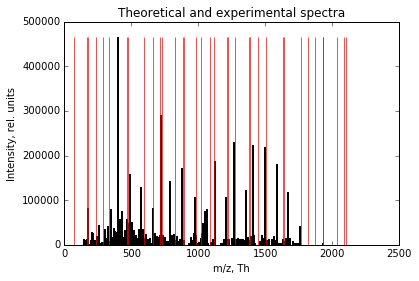

In [13]:
%matplotlib inline
import numpy as np
import pylab
pylab.figure()
pylab.title('Theoretical and experimental spectra')
pylab.xlabel('m/z, Th')
pylab.ylabel('Intensity, rel. units')
pylab.bar(expSpec[:,0], expSpec[:,1], width=0.1, linewidth=2,edgecolor='black')
theor_spectrum = list(ms.getAllFragmentsChargeX(peptideCands.loc[1645,'Sequence'],1).values())
theor_spectrum = np.vstack(theor_spectrum).flatten()
pylab.bar(theor_spectrum,[expSpec[:,1].max()]*len(theor_spectrum),width=0.1, edgecolor='red', alpha=0.7)

## Decoy peak matching

The **reversed decoy peptides** are filtered and the *in silico* y/b ions are derived in exactly the same manner as above.

In [14]:
decoyCands = ms.peptideCandidates(precursorMass,peptideDatabase=decoyPeptideData,massAccuracy=50)
decoyCands = ms.matchExpSpectrumToCandidatePeptides(expMZ,decoyCands,charge=precursorCharge,ms2tolerance=0.1)
print(decoyCands)

      Monoisotopic Mass             Sequence  Score
1660          2101.9246   GCMMEYMVVGLGWWDVAR      7
2146          2101.9341  SFAYHTNLQTSADSGNFDK      5


## Peptide Spectrum Match

For each spectrum, the top scoring peptide is selected as the **peptide spectrum match** (or PSM). Doing this for both the target and decoy database results in a target and decoy PSM as follows:

In [16]:
targetPSM = peptideCands.loc[peptideCands['Score'].idxmax()].copy()
targetPSM['Type'] = 'Target'
targetPSM['Spectrum'] = 'hela1ugul.2404.2404.2.dta'
targetPSM = targetPSM.drop('Monoisotopic Mass')

decoyPSM =decoyCands.loc[decoyCands['Score'].idxmax()].copy()
decoyPSM['Type'] = 'Decoy'
decoyPSM['Spectrum'] = 'hela1ugul.2404.2404.2.dta'
decoyPSM = decoyPSM.drop('Monoisotopic Mass')

print(targetPSM,'\n')
print(decoyPSM)

Sequence    SSGNSSSSGSGSGSTSAGSSSPGAR
Score                              41
Type                           Target
Spectrum    hela1ugul.2404.2404.2.dta
Name: 1657, dtype: object 

Sequence           GCMMEYMVVGLGWWDVAR
Score                               7
Type                            Decoy
Spectrum    hela1ugul.2404.2404.2.dta
Name: 1660, dtype: object


## Retrieving peptide spectrum matches for all the spectra

The following functions perform all of the procedures we described above, for all the specified spectra. When running this tool in the command line, all the .dta files in the specified folder will be considered.

All the intermediate steps (i.e. peptide scoring within a spectrum) are printed here for illustration purposes. The final dataframe at the bottom contains the top target and decoy PSM's for each spectrum.

In [17]:
import pandas as pd
def getPSM(spectrumFile,folderPath,ms1Tolerance,ms2Tolerance):
    """
    For the provided spectrum, the peptide spectrum match (PSM) and associated
    score will be computed by filtering peptide candidates from the peptide database,
    using the ms1 tolerance (default = 50 ppm), generating b/y ions
    and calculating their m/z values (with the parent charge minus 1, or 1 for singly charged parents),
    and finally counting the number of matching peaks between the experimental and
    theoretical peptide spectrum (using the ms2 tolerance 0.1 Da).
    The same procedure is repeated by searching against the decoy peptide database.

    Parameters
    ----------
    spectrumFile : str
        The file name of experimental spectrum .dta file.
    folderPath : str
        The folder containing the experimental spectra .dta files.
        Provided by the calling function matchAllSpectra().
    ms1tolerance : float
        The ms1 mass filtering error tolerance to use, in ppm.
    ms2tolerance : float
        The ms2 error tolerance to use during peak matching, in Dalton.

    Returns
    -------
    targetPSM : Series
        A pandas series containing the target PSM score and sequence.
    decoyPSM : Series
        A pandas series containing the decoy PSM score and sequence.
    """

    # Read in experimental spectrum
    expSpec = ms.importExperimentalSpectrum(os.path.normpath(os.path.join(folderPath,spectrumFile)))

    # Retrieve parent mass (M) and charge to use: parent charge minus 1 unless parent charge is 1 already
    precursorMass = ms.getPrecursorMass(expSpec)
    precursorCharge = ms.getPrecursorCharge(expSpec) if ms.getPrecursorCharge(expSpec)==1 else ms.getPrecursorCharge(expSpec)-1

    # Retrieve experimental m/z values
    expMZ = ms.getExperimentalMZs(expSpec)

    # Find peptide candidates in database
    peptideCands = ms.peptideCandidates(precursorMass,peptideDatabase=peptideData,massAccuracy=ms1Tolerance)

    # Calculate scores for peptide candidates - use precursor charge -1
    peptideCands = ms.matchExpSpectrumToCandidatePeptides(expMZ,peptideCands,charge=precursorCharge,ms2tolerance=ms2Tolerance)

    # Retrieve highest score = target peptide spectrum match
    targetPSM = peptideCands.loc[peptideCands['Score'].idxmax()].copy()
    targetPSM['Type'] = 'Target'
    targetPSM['Spectrum'] = spectrumFile
    targetPSM = targetPSM.drop('Monoisotopic Mass')

    # Find peptide candidates in decoys
    decoyCands = ms.peptideCandidates(precursorMass,peptideDatabase=decoyPeptideData,massAccuracy=ms1Tolerance)

    # Calculate scores for peptide candidates - use precursor charge -1
    decoyCands = ms.matchExpSpectrumToCandidatePeptides(expMZ,decoyCands,charge=precursorCharge,ms2tolerance=ms2Tolerance)

    # Retrieve highest decoy score = decoy peptide spectrum match
    decoyPSM =decoyCands.loc[decoyCands['Score'].idxmax()].copy()
    decoyPSM['Type'] = 'Decoy'
    decoyPSM['Spectrum'] = spectrumFile
    decoyPSM = decoyPSM.drop('Monoisotopic Mass')
    
    print('Peptide matching scores for experimental spectrum ',spectrumFile)
    print(peptideCands,'\n')
    print('Target PSM: ',targetPSM,'\n')
    print('Decoy matching scores for experimental spectrum ',spectrumFile)
    print(decoyCands,'\n')
    print('Decoy PSM: ',decoyPSM,'\n')

    return targetPSM,decoyPSM

def matchAllSpectra(pathToSpectra,ms1Tolerance,ms2Tolerance):
    """
    For all the provided spectra files, the target and decoy peptide spectrum match (PSM)
    is returned.

    See the function getPSM() for more details.

    Parameters
    ----------
    pathToSpectra : The absolute path to the spectra .dta files.
    ms1tolerance : float
        The ms1 mass filtering error tolerance to use, in ppm.
    ms2tolerance : float
        The ms2 error tolerance to use during peak matching, in Dalton.

    Returns
    -------
    spectrumScoreDatabase : DataFrame
        A pandas DataFrame containing target and decoy PSM scores for all spectra.
    """

    # Initialise dataframe to store results
    spectrumScoreDatabase = pd.DataFrame()

    for f in os.listdir(pathToSpectra):
        print('Processing',f)
        if f.endswith(".dta"):
            target,decoy = getPSM(f,folderPath=pathToSpectra,ms1Tolerance=ms1Tolerance,ms2Tolerance=ms2Tolerance)
            spectrumScoreDatabase = spectrumScoreDatabase.append([target,decoy])
        else:
            continue

    # sort scores
    spectrumScoreDatabase = spectrumScoreDatabase.sort_values('Score',ascending=False)

    return spectrumScoreDatabase

print(matchAllSpectra(spectraFilePath,ms1Tolerance=50,ms2Tolerance=0.1))

Processing hela1ugul.12566.12566.2.dta
Peptide matching scores for experimental spectrum  hela1ugul.12566.12566.2.dta
      Monoisotopic Mass             Sequence  Score
632           1899.8904    GPNPAFWWVNGQGDEVK      9
1659          1899.8010   LGIYDADGDGDFDVDDAK     26
2035          1899.8495    ANPMYNAVSNADLMDFK      4
2657          1899.8363      NNFEFCEAHIPFYNR      7
3030          1899.8017  TSSSSCSAHSSFSSTGQPR      6
3379          1899.7855     CFSLDAFCHHFSNMNK      7 

Target PSM:  Sequence             LGIYDADGDGDFDVDDAK
Score                                26
Type                             Target
Spectrum    hela1ugul.12566.12566.2.dta
Name: 1659, dtype: object 

Decoy matching scores for experimental spectrum  hela1ugul.12566.12566.2.dta
      Monoisotopic Mass            Sequence  Score
1730          1899.8010  ADDVDFDGDGDADYIGLK     19
3429          1899.7855    NMNSFHHCFADLSFCK      6 

Decoy PSM:  Sequence             ADDVDFDGDGDADYIGLK
Score                          

# Confidence assignment

In [13]:
peptideCands.loc[:,'P-value'] = peptideCands.apply(lambda row: (row['Score'] <= decoyCands.Score).sum() / decoyCands.Score.size,axis=1)


print(peptideCands)


      Monoisotopic Mass                   Sequence  Score  P-value
1645          2101.9246         AVDWWGLGVVMYEMMCGR      9      0.0
1657          2101.8744  SSGNSSSSGSGSGSTSAGSSSPGAR     41      0.0
1812          2101.8456        GDDEEGECSIDYVEMAVNK      5      1.0
2192          2101.9341        DFNGSDASTQLNTHYAFSK      6      0.5


This is a recommendation to repeat the search, using identical search parameters, against a database in which the sequences have been reversed or randomised. You do not expect to get any true matches from the "decoy" database. So, the number of matches that are found is an excellent estimate of the number of false positives that are present in the results from the real or "target" database


here: too small dataset for reliable estimate